In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import seaborn as sns
from sklearn.metrics import accuracy_score
import torch
from transformers import BertModel
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.nn.utils.clip_grad import clip_grad_norm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_fscore_support
import pickle

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
def open_dataset(mode, labeled):
    data = []
    if labeled:
        folder1 = f'/kaggle/input/imdb-dataset/{mode}/neg/'
        folder2 = f'/kaggle/input/imdb-dataset/{mode}/pos/'

        for filename in os.listdir(folder1):
            label = re.split(r'_', filename)[1][:-4]
            filepath = os.path.join(folder1, filename)
            with open(filepath, 'r', encoding="utf-8") as f:
                text = f.read()
            data.append((text, label))

        for filename in os.listdir(folder2):
            label = re.split(r'_', filename)[1][:-4]
            filepath = os.path.join(folder2, filename)
            with open(filepath, 'r', encoding="utf-8") as f:
                text = f.read()
            data.append((text, label))


        return pd.DataFrame(data, columns=['review', 'rating'])
    else:
        folder = '/kaggle/input/imdb-dataset/train/unsup/'

    
        for filename in os.listdir(folder):
            filepath = os.path.join(folder, filename)
            with open(filepath, 'r', encoding="utf-8") as f:
                text = f.read()
            data.append(text)
        return data

In [3]:
train_df = open_dataset('train', labeled=True)
test_df = open_dataset('test', labeled=True)

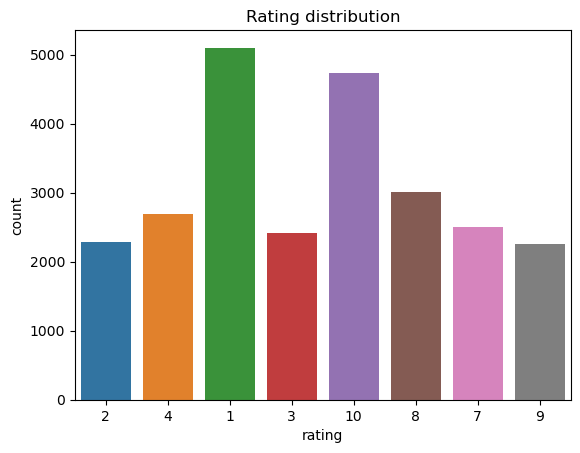

In [4]:
sns.countplot(x='rating', data=train_df)
plt.title('Rating distribution')
plt.show()

In [5]:
def preprocess_data_for_BERT(text):
    text = text.lower()
    text = re.sub(r'<br />', '', text)
    text = re.sub(r'[^\w\s!\\/]', '', text)
    pattern = r'(http\:\/\/|https\:\/\/)?([a-z0-9][a-z0-9\-]*\.)+[a-z][a-z\-]*'
    text = re.sub(pattern, '', text)
    return text

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_df['review'] = train_df['review'].apply(preprocess_data_for_BERT)
test_df['review'] = test_df['review'].apply(preprocess_data_for_BERT)
encoded_train = tokenizer(text=train_df.review.tolist(),
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=512,
                            return_attention_mask=True)
encoded_test = tokenizer(text=test_df.review.tolist(),
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=512,
                            return_attention_mask=True)


In [7]:
X_train = encoded_train['input_ids']
y_train = train_df['rating'].astype('float32').to_numpy()
X_test = encoded_test['input_ids']
y_test = test_df['rating'].astype('float32').to_numpy()
mask_train = encoded_train['attention_mask']
mask_test = encoded_test['attention_mask']

In [8]:
def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor, 
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            shuffle=True)
    return dataloader

In [9]:
batch_size = 16
train_dataloader = create_dataloaders(X_train, mask_train, 
                                      y_train, batch_size)
test_dataloader = create_dataloaders(X_test, mask_test, 
                                     y_test, batch_size)

In [10]:
class BertRegressor(nn.Module):
    def __init__(self, drop_rate = 0.2, freeze_bert = False):
        super(BertRegressor, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        d_in = 768
        d_out = 1
        self.regression_layer = nn.Sequential(

            nn.Dropout(drop_rate),
            nn.Linear(d_in, d_out)
        )
    def forward(self, X, masks):
        output = self.bert(X, masks)
        return self.regression_layer(output[1])

In [11]:
model = BertRegressor(drop_rate=0.2)
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
model.to(device)
model.load_state_dict(torch.load('/kaggle/input/bertmodel1/model.pth'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using GPU.


<All keys matched successfully>

In [12]:
def get_result(model, data_loader, device):
    model.eval()
    y_true, y_pred = [], []
    for batch in test_dataloader:
        batch_inputs, batch_masks, batch_labels = \
                                 tuple(b.to(device) for b in batch)
        # print(batch_inputs.shape, batch_labels)
        with torch.no_grad():
            outputs = model(batch_inputs, batch_masks)
        # print(outputs)
        y_pred.extend(torch.flatten(outputs.to('cpu')).tolist())
        y_true.extend(batch_labels.to('cpu').tolist())
        
    return y_true, y_pred

In [13]:
def transform(x):
    x = int(round(x))
    if x > 10:
        return 10
    if x < 1:
        return 1
    return x
def get_metrics(y_true, y_pred):
    metrics = []
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    metrics.append(('MSE', mse))
    simplify = lambda x: 1 if x >= 5 else 0
    y_true = [int(x) for x in y_true]
    y_pred = [transform(x) for x in y_pred]
    y_true_simple = [simplify(x) for x in y_true]
    y_pred_simple = [simplify(x) for x in y_pred]
    simple_accuracy = accuracy_score(y_pred=y_pred_simple, y_true=y_true_simple)
    metrics.append(('Accuracy for pos/neg', simple_accuracy))
    accuracy = accuracy_score(y_pred=y_pred, y_true=y_true)
    metrics.append(('Accuracy for multiple labels', accuracy))
    precision, recall, f_score, _ = precision_recall_fscore_support(y_pred=y_pred, y_true=y_true, average='weighted')
    metrics.append(('Precision', precision))
    metrics.append(('Recall', recall))
    metrics.append(('F-score', f_score))
    return pd.DataFrame(metrics, columns=['Metric', 'Value'])


In [14]:
y_true, y_pred = get_result(model, test_dataloader, 'cuda')

In [15]:
with open('datap1.pickle', 'wb') as f:
    pickle.dump(y_pred, f, pickle.HIGHEST_PROTOCOL)
with open('datat1.pickle', 'wb') as f:
    pickle.dump(y_true, f, pickle.HIGHEST_PROTOCOL)

In [16]:
test_results = get_metrics(y_true, y_pred)
test_results

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Metric,Value
0,MSE,2.417684
1,Accuracy for pos/neg,0.933880
2,Accuracy for multiple labels,0.459200
3,Precision,0.500495
4,Recall,0.459200
5,F-score,0.476674


In [17]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
epochs = 5
steps = epochs * len(train_dataloader)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=steps)
loss_function = nn.MSELoss()

In [18]:
def train(model, optimizer, scheduler, loss_function, epochs,       
          train_dataloader, device, clip_value=2):
    for epoch in range(epochs):
        print(epoch)
        print("-----")
        model.train()
        for step, batch in enumerate(train_dataloader): 
            batch_inputs, batch_masks, batch_labels = \
                               tuple(b.to(device) for b in batch)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)           
            loss = loss_function(outputs.squeeze(), 
                             batch_labels.squeeze())
            loss.backward()
            clip_grad_norm(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()
                
    return model
model = train(model, optimizer, scheduler, loss_function, epochs, 
              train_dataloader, device, clip_value=2)

0
-----


/tmp/ipykernel_22/613805806.py:15: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  clip_grad_norm(model.parameters(), clip_value)


1
-----
2
-----
3
-----
4
-----


In [19]:
torch.save(model.state_dict(), 'model2.pth')

In [20]:
y_true, y_pred = get_result(model, test_dataloader, 'cuda')

In [21]:
test_results = get_metrics(y_true, y_pred)
test_results

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Metric,Value
0,MSE,2.525892
1,Accuracy for pos/neg,0.933480
2,Accuracy for multiple labels,0.460360
3,Precision,0.508720
4,Recall,0.460360
5,F-score,0.478250


In [22]:
with open('datap2.pickle', 'wb') as f:
    pickle.dump(y_pred, f, pickle.HIGHEST_PROTOCOL)
with open('datat2.pickle', 'wb') as f:
    pickle.dump(y_true, f, pickle.HIGHEST_PROTOCOL)